# Оптимизация потребление электроэнергии на этапе обработки стали.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.
Описание этапа обработки
​
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
​
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
​
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).
​
Наша задача обработать данные и на этих данных обучить модели для прогнозирования конечной температуры.
Условия для моделей пронозирования:
​
- random_state=12923
- test_size=25%
- делим на две выборки и используем  кросс-валидацию, тестируем одну модель, выбранную на кросс-валидации/
- минимальный порог МАЕ<= 6.8.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Первичный анализ датасетов

#### Анализ данных по электродам.

In [2]:
#данные об электродах
arc=pd.read_csv('/datasets/data_arc_new.csv')
print(arc.head())
arc.info()

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реак

In [3]:
print('Количество пропусков')
arc.isnull().sum()

Количество пропусков


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [4]:
# Описатаельная статистика.
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [5]:
# Убираем выброс
arc_clean=arc[arc['Реактивная мощность'] >= -715]

AxesSubplot(0.125,0.125;0.775x0.755)


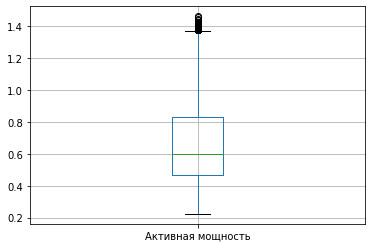

In [6]:
#Boxplot активной мощности
print(arc_clean.boxplot(column=['Активная мощность'], grid=True))

AxesSubplot(0.125,0.125;0.775x0.755)


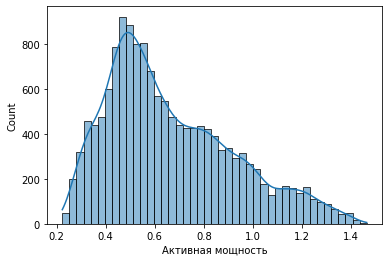

In [7]:
#Гистограммы распределения активной и реактивной мощности.
print(sns.histplot(x=arc_clean['Активная мощность'], kde=True))

AxesSubplot(0.125,0.125;0.775x0.755)


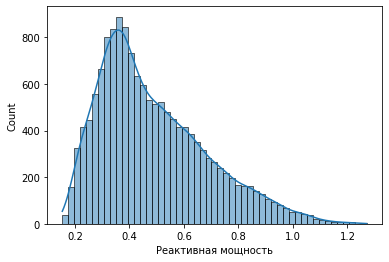

In [8]:
print(sns.histplot(x=arc_clean['Реактивная мощность'], kde=True))


In [9]:
# Кэф корреляции
arc_clean['Реактивная мощность'].corr(arc_clean['Активная мощность'])

0.9663734456187294

In [10]:
print("Количество партий ",arc['key'].nunique())

Количество партий  3214


In [11]:
print('Количество пропущенных значений')
arc.isnull().sum()

Количество пропущенных значений


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [12]:
('Кол-во дубликатов:', arc.duplicated().sum())

('Кол-во дубликатов:', 0)

* Выводы *

-по электродам все данные без пропусков.

-дубликаты отсутствуют.

-есть явный выброс-большое отрицательное значение реактивной мощности.

-между активной и реактивной мощностью практически 100 процентная связь.На основании этих признаков создать новый - Полная мощность,которая вычисляется по формуле:

Полная мощность = (Активная мощность^2 + Реактивная мощность^2)^1/2, тем самым убрав практически линейную зависимость между 2мя признаками,объединив их в 1.

Также добавим новый признак - время нагрева. И на основании 2 новых признаков рассчитаем работу.

#### Анализ данных по сыпучим материалам (объем)

In [13]:
#данные о подаче сыпучих материалов (объём)
bulk=pd.read_csv('/datasets/data_bulk_new.csv')
print(bulk.head())
bulk.info()

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   

In [14]:
# Описательная статитстика.
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


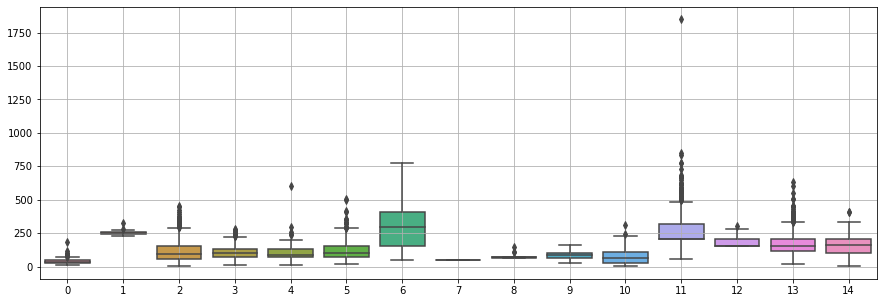

In [15]:
###Boxplot по всем подачам сыпучим материалам.
plt.figure(figsize=(15,5))
sns.boxplot(data=bulk.iloc[:,1:].values)
plt.grid();

In [16]:
print("Количество партий ",bulk['key'].nunique())

Количество партий  3129


In [17]:
print('Количество пропущенных значений')
bulk.isnull().sum()

Количество пропущенных значений


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [18]:
('Кол-во дубликатов:', bulk.duplicated().sum())

('Кол-во дубликатов:', 0)

*** Выводы ***

-Дубликаты отсутствуют.

-Есть единичный выброс в подаче Bulk12

-Много пропущенных значений. В датафреймах data_bulk и data_bulk_time 16 признаков, из них во всех признаках Bulk есть пропуски, причем пропуски в датафреймах совпадает. Вероятнее всего, это говорит об отсутствие засыпки на определенном этапе. Т.о образом пропущенные значения в этом датасете мы заполним "0".

#### Анализ данных по сыпучим материалам (время)

In [19]:
#данные о подаче сыпучих материалов (время)
bulk_time=pd.read_csv('/datasets/data_bulk_time_new.csv')
print(bulk_time.head())
bulk_time.info()

   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  


In [20]:
bulk_time.isnull().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

#### Анализ  данных о продувке сплава газом. 

In [21]:
#данные о продувке сплава газом
gas=pd.read_csv('/datasets/data_gas_new.csv')
print(gas.head())
gas.info()

   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [22]:
# Описательная статистика
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


AxesSubplot(0.125,0.125;0.775x0.755)


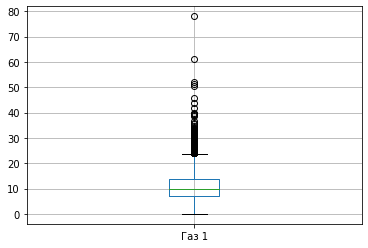

In [23]:
# Boxplot 
print(gas.boxplot(column=['Газ 1'], grid=True))

In [24]:
gas.loc[gas['Газ 1']>70]

,key,Газ 1
319,322,77.99504


<AxesSubplot:xlabel='Газ 1', ylabel='Count'>

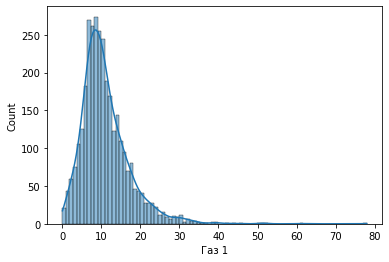

In [25]:
(sns.histplot(x=gas['Газ 1'], kde=True))

In [26]:
print("Количество партий ",gas['key'].nunique())

Количество партий  3239


In [27]:
print('Количество пропущенных значений')
gas.isnull().sum()

Количество пропущенных значений


key      0
Газ 1    0
dtype: int64

In [28]:
('Кол-во дубликатов:', gas.duplicated().sum())

('Кол-во дубликатов:', 0)

*** Выводы ***

-В данных по газу пропусков нет.

-Есть выброс при значении выше 70.

-Дубликатов нет.

#### Анализ данных по температуре 

In [29]:
# Данные о температуре
temp=pd.read_csv('/datasets/data_temp_new.csv')
print(temp.head())
temp.info()

   key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [30]:
# описательная статистика
temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


AxesSubplot(0.125,0.125;0.775x0.755)


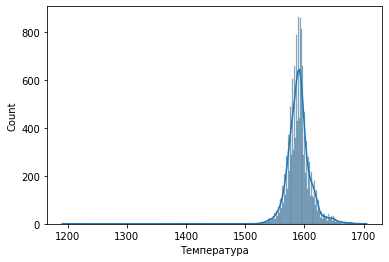

In [31]:
print(sns.histplot(x=temp['Температура'], kde=True))

AxesSubplot(0.125,0.125;0.775x0.755)


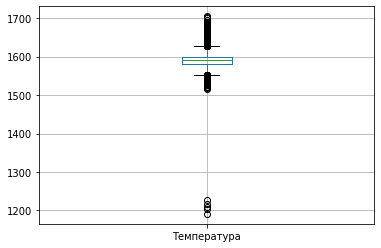

In [32]:
print(temp.boxplot(column=['Температура'], grid=True))

In [33]:
print("Количество партий ",temp['key'].nunique())

Количество партий  3216


In [34]:
print('Количество пропущенных значений')
temp.isnull().sum()

Количество пропущенных значений


key                0
Время замера       0
Температура     3427
dtype: int64


* Выводы *

-3427 отсутствующих значений. На этапе предобработки их логичнее удалить,т.к замены логичной им нет.

-скопление выбросов в нижней части( что также видно на графике распределения),эти выбросы необходимо удалить по условию заказчика( необходимо исключить замеры темппература ниже 1500, как раз эти значения и попали в выбросы)

-по значениям Key видно ,что в партиях могло быть несколько замеров. Эти данные необходимо будет сгруппировать,для выделения начальной температуры и конечной температуры (целевой признак).

#### Анализ проволочных материалов(объем)

In [35]:
#данные о проволочных материалах (объём);
wire=pd.read_csv('/datasets/data_wire_new.csv')
print(wire.head())
wire.info()

   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non

In [36]:
# Описательная статистика
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


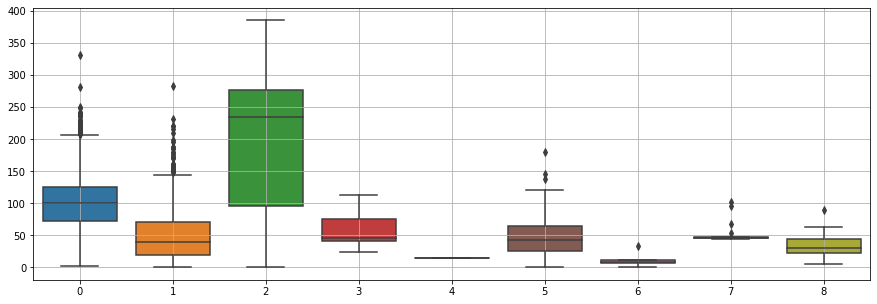

In [37]:
###Boxplot
plt.figure(figsize=(15,5))
sns.boxplot(data=wire.iloc[:,1:].values)
plt.grid();

In [38]:
print("Количество партий ",wire['key'].nunique())

Количество партий  3081


In [39]:
('Кол-во дубликатов:', wire.duplicated().sum())

('Кол-во дубликатов:', 0)

*** Выводы ***

-дубликатов нет.

-выбросов нет.

-много пропусков,но здесь ситуация аналогична данным по сыпучим материалам.Скорее всего пропуски - просто неподача проволоки. и отсутствующие данные заполним 0.

#### Проволочных материалов (время)

In [40]:
#данные о проволочных материалах (время)
wire_time=pd.read_csv('/datasets/data_wire_time_new.csv')
print(wire_time.head())
wire_time.info()

   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 

In [41]:
wire_time.isnull().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

*** 1. Произвести очистку по всем выбросам в данных. Необработанные выбросы остались в датасете о продувке сплава газом,замерах температуры.***

*** 2.Заполнение отсутствующих данных в объемах сыпучих и проволочных материалах ***

*** 3.Создание единой сводной таблицы по ключу партии. Нас будут интересовать те данные,ключи которых есть во  всех таблицах. Нужно это учесть при объединении, т.к по анализу видно ,что в партиях количество замеров разное.***

*** 3.1 Для того,что выполнить третий пункт необходима  группировка  в данных по  электродам  с созданием нового признака.
Этим признаком станет Работа ( время * полную мощность). После создания старые признаки будут удалены. ***

*** 3.2 также необходима группировка в замерах температуры. Нам необходимо выделить первый замер и последний в партии (он станет целевым признаком). ***

*** 4. Объеденим все значения датасетов по значению Key.В финальном датасете останутся признаки:***

-начальная температура,

-работа,

-продувка инертным газом,

-объемы всех подач по партиям сыпучих веществ,

-объем всех подач по партиям проволоки,

-Конечная температура,которая будет целевым признаком.

*** На этом EDA будет завершена и можно приступатьк обучению моделей. ***

*** 5. Разделение на выборки 3:1 6. Обучение моделей с кросс-валидацией и выбор лучшей по показателю MAE. в качестве моделей используем: ***

-LinearRegression

-RandomForestRegressor

-LgbmRegressor

*** 6. Расчет MAE на тестовой выборке лучшей модели на обучении . ***

*** 7.Анализ значимости признаков для предсказания ***

*** 8.Общий вывод ***

# Обработка выбросов.

## Обработка выбросов в замере температуре.

In [42]:
#Выделение данных с отсутствием замера температуры 
empty=temp[temp['Температура'].isnull()]

In [43]:
#Выделение ключей партий с отсутвующими замерами.
key_to_delete=empty['key'].unique().tolist()

In [44]:
#Удаление партий из датасета
temp_clean=temp[temp['key'].isin(key_to_delete) == False]

In [45]:
temp_clean.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [46]:
#Выделение партий с аномалиями в замерах.
empty_1500=temp_clean.query('Температура < 1500')

key_to_delete_1500=empty_1500['key'].unique().tolist()

In [47]:
temp_clean=temp_clean[temp_clean['key'].isin(key_to_delete_1500) == False]
temp_clean.describe()

,key,Температура
count,13905.00000,13905.000000
mean,1243.32571,1590.924847
std,719.39552,18.750314
min,1.00000,1519.000000
25%,623.00000,1580.000000
50%,1246.00000,1590.000000
75%,1870.00000,1599.000000
max,2499.00000,1705.000000


## Обработка выбросов в объеме сыпучих материалов.


In [48]:
# Выброс в сыпучих материалах 
bulk[bulk['Bulk 12'] > 1000]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


*** В данной партии было задействовано много сыпучих материалов,т.е эти данные в bulk 12 ,возможно, не ошибка и данные стоит оставить.***

## Обработка выбросов в объеме продувки газом.

In [49]:
#Выброс в данных газа
gas.loc[gas['Газ 1']>70]

,key,Газ 1
319,322,77.99504


# Заполнение отсутствующих значений.

In [50]:
wire_clean=wire.fillna(0)
bulk_clean=bulk.fillna(0)

# Создание признаков "Время нагрева" и "Полной мощности" в данных об электродах.

In [51]:
#Переведем к нужному формату
arc_clean['Конец нагрева дугой']=pd.to_datetime(arc_clean['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
arc_clean['Начало нагрева дугой']=pd.to_datetime(arc_clean['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
#Создадим признак времени нагрева и переведем ее в секунды.
arc_clean['Время нагрева']=(arc_clean['Конец нагрева дугой']-arc_clean['Начало нагрева дугой']).dt.seconds
arc_clean['Время нагрева'].head(5)

0    228
1    185
2    172
3    365
4    148
Name: Время нагрева, dtype: int64

In [52]:
#Посчитаем полную мощность
arc_clean['Полная мощность']=((arc_clean['Активная мощность'])**2+(arc_clean['Реактивная мощность'])**2)**0.5
arc_clean['Полная мощность'].head(5)

0    0.371123
1    0.902319
2    0.722536
3    0.642824
4    1.079934
Name: Полная мощность, dtype: float64

In [53]:
#Теперь нам необходимо сгруппировать Работу по партиям
arc_clean=arc_clean.groupby('key')['Полная мощность', 'Время нагрева']. sum().reset_index()
arc_clean.head()


,key,Полная мощность,Время нагрева
0,1,3.718736,1098
1,2,2.588349,811
2,3,5.019223,655
3,4,3.400038,741
4,5,2.816980,869


# Создание признаков "начальной" и "конечной" температуры" .

In [54]:
#Выстроим данные по времени замера.
temp_clean=temp_clean.sort_values(by='Время замера')

print('Количество пропущенных значений')
temp_clean.isnull().sum()

Количество пропущенных значений


key             0
Время замера    0
Температура     0
dtype: int64

In [55]:
# Группировка по ключу и выделение первого и последнего замера.
temp_clean=temp_clean.groupby(by = 'key', as_index = False).agg(['first', 'last'])

In [56]:
# Переименуем колонки
temp_clean.columns = ['Время первого замера','Время последнего замера','Температура_начальная', 'Температура_конечная']

In [57]:
# Удаление расчетных признаков
temp_clean.drop(['Время первого замера', 'Время последнего замера'], axis= 1 , inplace= True )
temp_clean.head()

,Температура_начальная,Температура_конечная
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


# Сведение данных в единую таблицу.

In [58]:

# К таблице с целевым признаком последовательно присединим данные по ключу.Замеры температуры и данные электродам
final_date = pd.merge(temp_clean, arc_clean, on='key')
#Объединенная+данные по сыпучим материалам
final_date=pd.merge(final_date,wire_clean, on='key')
#Объединенная+данные по проволоке
final_date=pd.merge(final_date,bulk_clean, on='key')
#Объедиенная + данные о продувке газом
final_date=pd.merge(final_date,gas, on='key')

In [59]:
#Удаление пустого признака wire 5
final_date=final_date.drop(['Wire 5'], axis= 1 )

In [60]:
# Удаление номера партии.
final_date=final_date.drop(['key'], axis= 1 )

In [61]:
#Удаление сильно коррелирующего признак Wire 8, т.к его объем меньше по соотношению в своем классе добавок
final_date=final_date.drop(['Wire 8'], axis= 1 )

<AxesSubplot:>

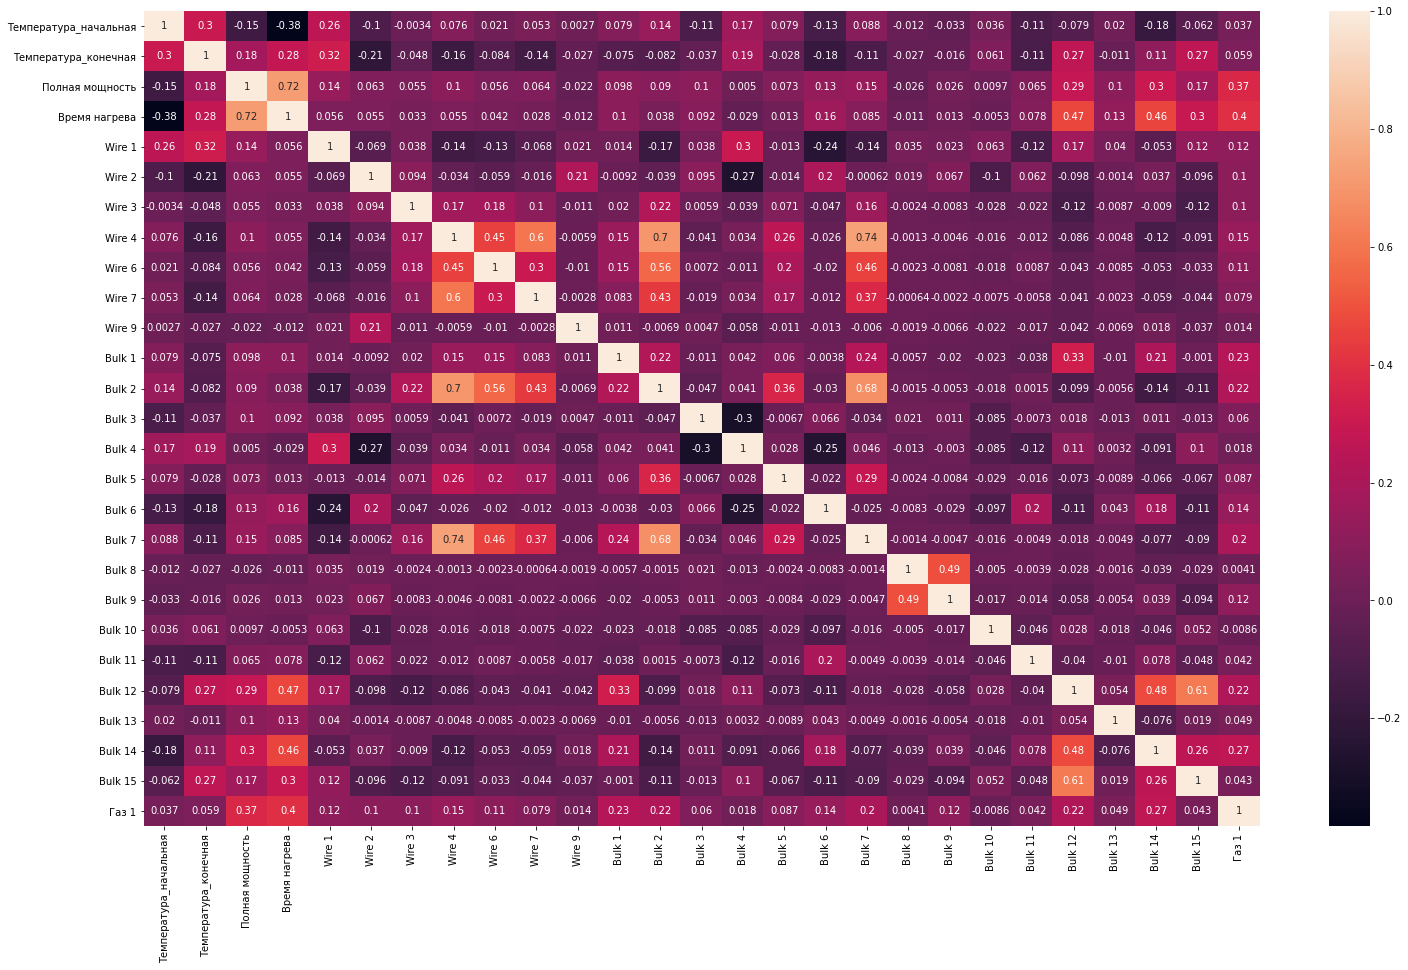

In [62]:
# Матрица корреляции нового датасета признаков
corr_matrix = final_date.corr()
plt.figure(figsize=(25,15))
sns.heatmap(corr_matrix, annot=True)

*** Наблюдаютс отдельные пары с коэф 0.7 или близкие к нему, но такие пары единичны ***

In [63]:
#Переименуем столбцы 
final_date.rename(columns = {'Полная мощность':'full_power','Время нагрева':'time_temp','Газ 1':'gas','Температура_начальная':'temp_first','Температура_конечная':'temp_last'}, inplace = True )

In [64]:
final_date.describe()

,temp_first,temp_last,full_power,time_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1587.365161,1593.366022,3.885528,807.988387,102.412198,17.605637,3.240481,0.307077,0.980504,0.006371,...,2.008172,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,11.378942
std,23.623144,11.209581,1.517546,340.888430,43.535263,33.642919,27.966585,4.761821,8.700682,0.205882,...,30.702509,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,6.395632
min,1519.000000,1541.000000,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399
25%,1571.000000,1587.000000,2.844193,581.000000,73.207679,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948
50%,1587.000000,1593.000000,3.769823,778.000000,101.087998,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950
75%,1603.000000,1598.000000,4.769421,993.000000,128.069763,23.102560,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,14.217691
max,1660.000000,1653.000000,15.288271,4189.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,...,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040


# Обучение моделей.

# Разбивка на обучающую и тестовую выборки.

In [65]:
#Выделение целевого значения и признаков
target=final_date['temp_last']
features=final_date.drop(['temp_last'], axis= 1)

In [66]:
# Разбивка на тренировочную и тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12923)
print('Размер тренировочной выборки',features_train.shape)
print('Размер тестовой выборки',features_test.shape)

Размер тренировочной выборки (1743, 26)
Размер тестовой выборки (582, 26)


# Линейная регрессия

In [67]:
lr = make_pipeline(StandardScaler(), LinearRegression())
lr_params = {'linearregression__normalize':[False]}
grid_lr = GridSearchCV(lr, param_grid=lr_params, scoring='neg_mean_absolute_error',cv=5)
grid_lr.fit(features_train, target_train)
print("Лучшие параметры: ", grid_lr.best_params_)
print("MAE на СV Линейной регрессии : ", -grid_lr.best_score_)

print()

Лучшие параметры:  {'linearregression__normalize': False}
MAE на СV Линейной регрессии :  6.276202390696395



# RandomForrestRegression

In [68]:
rfr = RandomForestRegressor() 

rfr_params = [{'criterion':['mae'],
               'n_estimators':[x for x in range(100, 501, 50)],
               'random_state':[12923]}]
gscv = RandomizedSearchCV(rfr, rfr_params, scoring='neg_mean_absolute_error', cv=5)
gscv.fit(features_train, target_train)
print("Лучшие параметры: ", gscv.best_params_)
print("MAE на СV RFR : ", -gscv.best_score_)


Лучшие параметры:  {'random_state': 12923, 'n_estimators': 350, 'criterion': 'mae'}
MAE на СV RFR :  6.282416152648196


# LGBM

In [ ]:
lgbm = LGBMRegressor() 
lgbm_params = [{'num_leaves':[x for x in range(10,26)],
                #'max_depth':[x for x in range(10,25)],
                'learning_rate':[.1],
                'random_state':[12923]}]

gscv =GridSearchCV(lgbm, lgbm_params, scoring='neg_mean_absolute_error', cv=7)

gscv.fit(features_train, target_train)

print("Лучшие параметры: ", gscv.best_params_)
print("MAE на СV Lgbm : ", -gscv.best_score_)

In [72]:
# Объединение результатов в одну таблицу результаты
index = ['LinearRegression', 'RandomForestRegressor','LGBMRegressor',]

data = {'MAE на обучающей выборке': [6.27,6.28,6.26,]}

kpi = pd.DataFrame(data=data, index=index)

kpi.sort_values(by='MAE на обучающей выборке', ascending=False)

,MAE на обучающей выборке
RandomForestRegressor,6.28
LinearRegression,6.27
LGBMRegressor,6.26


# Проверка на тестовой выборке

In [73]:
# Инициация модели с лучшими параметрами
lgbm = LGBMRegressor(learning_rate = 0.1, num_leaves=12,random_state=12923)
lgbm.fit(features_train, target_train)
predict = lgbm.predict(features_test)
MAE_lgbm  = mean_absolute_error(target_test, predict)
print('MAE для Lgbm',MAE_lgbm)

MAE для Lgbm 6.3202218765543


***На тестовой выборке минимальное MAE достигнуто***

***В итоге лучшую метрику MAE показала модель LGBM c параметрами learning_rate = 0.1, num_leaves=12,random_state=12923.***

# Проверка значимости параметров 

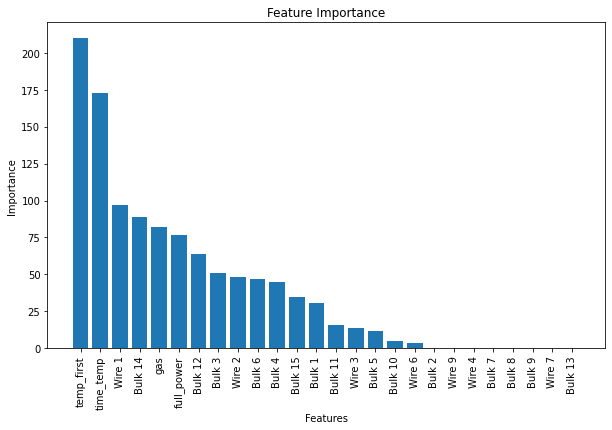

In [74]:
# Определение важности признаков
feature_importance = lgbm.feature_importances_

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'feature': features_train.columns, 'importance': feature_importance})

# Сортировка признаков по важности
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Отчет по проекту :"Промышленность:оптимизация энергопотребления на этапе выплавки стали."

# Цель проекта.

**С помощью моделей машиннго обучения спрогнозировать коне
чную температуру на этапе обработки стали для оптимизации энергопотребления и снижение производственных расходов.** 

# Данные  проекта.

**Были предоставлены следущие данные с разбивкой по партиям плавления в нескольких датасетах.**

**-Замеры температуры в партиях(в партиях различное количество замеров)(с пропущенными значениями)**

**-Данные по партиям о количестве примененных сыпучих материалов и проволоки.(с пропущенными значениями)**

**-Данные о продувке партии газом.**

**-Данные о времени нагрева электродов а показатель активной и реактивной мощности во время нагрева** 

***Целевое значение - последний замер температуры в партии***

# План

**После после первичного исследования данных был составлен план , включавший в себя обработку(проверка и удаление аномальных значений,заполнение пропущенных),введение новых признаков и удаление расчетных, группировку данных по партиям и сведение их в единый датасет, обучение моделей,выбор лучшей, проверка модели на тестовых данных и анализ значимости каждого из признаков. Критерием качества моделей была минимизация метрики МАЕ(измеряет среднее абсолютное отклонение между предсказанными значениями и фактическими значениями и показывает насколько точно модель предсказывает целевую переменную).**

**Расчетное значение MAE на тестовых данных не должно превышать 6.8** 

**Все шаги плана удалось выполнить,однако,потребовались корректировки признаков после проведения моделирования для улучшения метрики.**

# Моделирование .

**1.Обработка данных.**

**На этом этапе мы провели анализ данных на аномальные/отсутствующие данные. В частности удалена партия с мощностью равной -750. Были исключеные партии с пропущенными значениями температуры(целевой признак не рекомендуется восстанвливать,если нет четких логичных замен,чтобы не искажать моделирование) ,а также исключены партии с аномальными показателями ттемпературы меньше 1500.**

**Также были удалена пустая партия 'Wire 5' и один из 2х сильновзаимосвязанных признаков:"Wire 8"**

**2.Введение новых признаков.**

**На первоначальном этапе из имеющихся данных были сформированы признак суммарного времени нагрева электродами и полной мощности, а на их основании рассчитана энергия ,затраченная на выплавку. Однако, после моделирования , было решено оставить эти признаки без объединения,что позволило модели более точно рассчитать требуемую метрику** 

**После группировки были сформированы признаки первого и последнего замера в партии.**

**В конечном датасете в обучающем пуле данных остались признаки:**

-начальной температуры,

-полной мощности,

-время нагрева,

-продувка газом,

-все данные о добавке сыпучих материалов и проволоки.

**3.Обучение моделей.**

**В качестве обучающих моделей были выбраны регрессионные модели : LinearRegression,RandomForrestRegression и LGBM.**

**Модели были обучены на подготовленных ранее данных.**

**Осуществлен подбор гиперпараметров с помощью RandomizedSearchCV**

**На данном этапе , к сожалению , столкнулись с существенным ограничением по вычислительной мощности,что не позволило добавить большее количество гиперпараметров в модели.Также можно было увеличить количество фолдов перекрестных проверок и использовать    более точный оптимизатор GridSearch.Но целевое значение было получено.**

**4.Лучшая модель.**

**Лучшей моделью оказалась LGBM(основана на деревьях решений и использует градиентный спуск для обучения модели) c параметрами learning_rate = 0.1, num_leaves=12,random_state=12923.**

**МАЕ на тестовой выборке = 6.32,что соответствует условию критерия качества модели**



# Рекомендации заказчикам.

**1.Важность признаков**

**После определения лучшей модели был произведен анализ важности признаков. Самыми значимыми оказались первичный нагрев и время работы элетродов(Технолические характеристики), среди сыпучих материалов - материал из признака Bulk14, из проволоки Wire1,а также продувка газом. Эти 5 признаков влияют на конечную температуру больше всего. Поэтому для дальнейшего контроля в первую очередь стоит уделить внимание им.**

**Далее я хотел бы дать рекомендации по улучшению имеющегося решения.**

**2.Дальнейший сбор информации**

**На мой взгляд имеет смысл ввести еще один признак,отвечающий за различие видов сталей(например,категоральной переменной по марке стали или создание нового датасета). По данным сыпучих материалов и проволоки видно,что они в разных партиях подаются в разных объемах ,скорее всего это связано с видом плавящайся стали,хотя процесс плавки одинаковый.Это должно повысить точность модели.** 


**3.В дальнейшем попробовать расширить ансамбль гиперпараметров lgbmмодели,а также увеличить количество фолдов при перекрестной проверке.** 

# Заключение

**Проект "Оптимизация потребление электроэнергии на этапе обработки стали." выполнен, Lgbmmodel,обученная на сформированных данных ,позволяет прогнозировать температуру с заданной точностью,что позволит компании снизить затраты электропотребления  на производстве.**